# ACTIVIDAD 2: REDES NEURONALES CONVOLUCIONALES

---

En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Carga de los datos

In [1]:
import cv2
import os
import numpy as np
import keras
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf

from sklearn.model_selection import train_test_split

In [2]:
# RANDOM SEED
np.random.seed(202)

In [ ]:
# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz",
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets


# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz",
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

In [ ]:
# Descomprimimos el archivo en tmp para visualizar
# !tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /tmp/simpsons

In [3]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel',
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson',
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak',
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 60

In [4]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.

    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.

    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas

    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [5]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [6]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "datasets/simpsons"
DATASET_TEST_PATH_COLAB = "datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_test, y_test = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [7]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

abraham_grampa_simpson


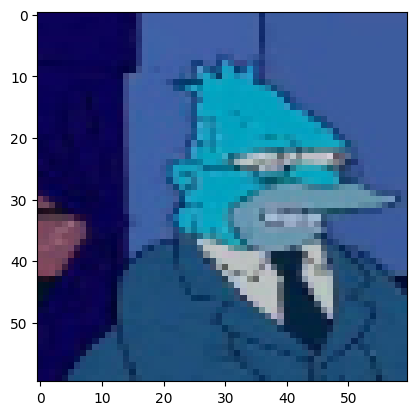

In [8]:
plt.imshow(X_test[2]) # recordad que siempre es preferible trabajar en blanco y negro
print(MAP_CHARACTERS[y_test[2]])

## Ejercicio

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de, al menos, **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas:
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

In [9]:
# TENSORFLOW GPU SUPPORT
# ======================
if tf.test.gpu_device_name():
    print("GPU support enabled.")
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("GPU support disabled.")

GPU support enabled.
Default GPU Device: /device:GPU:0


2024-05-26 20:01:02.128179: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-05-26 20:01:02.128219: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-05-26 20:01:02.128228: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-05-26 20:01:02.128256: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-26 20:01:02.128277: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-05-26 20:01:02.134701: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been bui

In [10]:
# TENSORFLOW TPU SUPPORT
# ======================
HAS_TPU_SUPPORT=0
if 'COLAB_TPU_ADDR' not in os.environ:
  print('TPU support disabled.')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU support enabled.')
  HAS_TPU_SUPPORT=1
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()

  print('TPU devices:')
  pprint.pprint(devices)

TPU support disabled.


In [11]:
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

## 1. Análisis de datos y preparación

El conjunto de datos, originalmente, viene preparado en:
- Datos de entrenamiento.
- Datos de test.

Sin embargo, nos faltaría un conjunto de datos útil: el de validación.

In [12]:
# De los datos de entrenamiento sacamos un 20% de datos para validación.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=202)

Tenemos el siguiente conjunto de datos:
- Entrenamiento: X_train, y_train
- Test: X_test, y_test
- Validación: X_val, y_val

In [13]:
# Variables con numero de elementos
X_train_num_elem = X_train.shape[0]
X_test_num_elem = X_test.shape[0]
X_val_num_elem = X_val.shape[0]

In [14]:
# Dimensiones
img_rows = IMG_SIZE
img_cols = IMG_SIZE
img_channels = X.shape[3]

In [15]:
# Número de categorías
num_categ = len(MAP_CHARACTERS)

In [16]:
# Comprobamos que efectivamente los resultados son los esperados
print("Número de imágenes de anterior training : " + str(X.shape[0]))
print("Número de imágenes de training (80% de anterior train) : " + str(X_train_num_elem))
print("Número de imágenes de validación (20% de anterior train) : " + str(X_val_num_elem))
print("Número de imágenes de test : " + str(X_test_num_elem))
print("====")
print("Número de resultados de anterior training : " + str(y.shape[0]))
print("Número de resultados de training (80% de anterior train) : " + str(y_train.shape[0]))
print("Número de resultadoss de validación (20% de anterior train) : " + str(y_val.shape[0]))
print("Número de resultados de test : " + str(y_test.shape[0]))
print("====")
print("Dimensiones de training : " + str(X_train.shape))
print("Dimensiones de validation : " + str(X_val.shape))
print("Dimensiones de tests : " + str(X_test.shape))
print("====")
print("Canales de color para las imagenes : "+ str(img_channels))
print("Resolución imágenes de anterior training : " + str(X.shape[1]) + "x" + str(X.shape[2]))
print("Resolución imágenes de training (80% de anterior train) : " + str(X_train.shape[1]) + "x" + str(X_train.shape[2]))
print("Resolución imágenes de validación (20% de anterior train) : " + str(X_val.shape[1]) + "x" + str(X_val.shape[2]))
print("Resolución imágenes de test : " + str(X_test.shape[1]) + "x" + str(X_test.shape[2]))

Número de imágenes de anterior training : 18992
Número de imágenes de training (80% de anterior train) : 15193
Número de imágenes de validación (20% de anterior train) : 3799
Número de imágenes de test : 890
====
Número de resultados de anterior training : 18992
Número de resultados de training (80% de anterior train) : 15193
Número de resultadoss de validación (20% de anterior train) : 3799
Número de resultados de test : 890
====
Dimensiones de training : (15193, 60, 60, 3)
Dimensiones de validation : (3799, 60, 60, 3)
Dimensiones de tests : (890, 60, 60, 3)
====
Canales de color para las imagenes : 3
Resolución imágenes de anterior training : 60x60
Resolución imágenes de training (80% de anterior train) : 60x60
Resolución imágenes de validación (20% de anterior train) : 60x60
Resolución imágenes de test : 60x60


In [17]:
# Comprobamos el formato de cada muestra...
if keras.backend.image_data_format() == "channels_first":
  # ...si los canales van primero (channels, rows, cols):
  X_train = X_train.reshape(X_train.shape[0], img_channels, img_rows, img_cols)
  X_val = X_val.reshape(X_val.shape[0], img_channels, img_rows, img_cols)
  X_test = X_test.reshape(X_test.shape[0], img_channels, img_rows, img_cols)
  input_shape = (img_channels, img_rows, img_cols)
else:
  # ...sino, si los canales van último (rows, cols, channels):
  X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, img_channels)
  X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, img_channels)
  X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, img_channels)
  input_shape = (img_rows, img_cols, img_channels)

## 2. Normalización de datos

Como hicimos en la primera práctica, tenemos que normalizar los datos

In [18]:
# Normalizamos y convertimos a float32, de tal manera que seamos capaces de tener valores entre 0 y 1
X_train = X_train.astype("float32")
X_val = X_val.astype("float32")
X_test = X_test.astype("float32")

# Con esto obtenemos valores entre el rango 0...1
X_train /= 255
X_val /= 255
X_test /= 255

# Con esto conseguimos trabajar con categorías en las y (las etiquetas)
y_train = keras.utils.to_categorical(y_train, num_categ)
y_val = keras.utils.to_categorical(y_val, num_categ)
y_test = keras.utils.to_categorical(y_test, num_categ)

Asi, ya tendríamos preparados todos los conjuntos de datos para poner a definir los modelos con los que vamos a trabajar.

## 3. Entrenamiento

Pasamos a definir los modelos:

| Nombre modelo | Cant. capas | Func. act. | Optimizador | Caracts. extra |
| ------------- | ----------- | ---------- | ----------- | -------------- |
|       M1      |      2      |    Relu    |   Adagrad   |                   |
|       M2      |      .      |    .       |      .      |      Fully conn.  |
|       M3      |      4      |    Relu    |   RMSProp      |                |
|       M4      |      6      |    Relu    |   Adadelta  |   Batch norm.        |
|       M5      |      4      |    Relu    |   RMSProp   |   Batch norm. + Data augm.   |

==========================
#### 3.1. M1

In [19]:
# Definimos aquí más imports para no tener que ir más arriba en el notebook
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, AveragePooling2D
from tensorflow.keras.optimizers import Adam, Adagrad, Adadelta, RMSprop

In [20]:
m1 = Sequential()
m1.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=input_shape, name="m1_conv2d_1"))
m1.add(Conv2D(64, kernel_size=(3, 3), activation="relu", input_shape=input_shape, name="m1_conv2d_2"))
m1.add(MaxPooling2D(pool_size=(2, 2), name="m1_maxpool2d_1"))
m1.add(Dropout(0.25, name="m1_dropout_1"))
m1.add(Flatten(name="m1_flatten"))
m1.add(Dense(128, activation="relu", name="m1_dense_1"))
m1.add(Dropout(0.5, name="m1_dropout_2"))
m1.add(Dense(num_categ, activation="softmax", name="m1_softmax"))

m1.summary()

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-26 20:01:33.490870: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-26 20:01:33.490901: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ m1_conv2d_1 (Conv2D)            │ (None, 58, 58, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m1_conv2d_2 (Conv2D)            │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m1_maxpool2d_1 (MaxPooling2D)   │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m1_dropout_1 (Dropout)          │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m1_flatten (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m1_dense_1 (Dense)              │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m1_dropout_2 (Dropout)          │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m1_softmax (Dense)              │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,444,370 (24.58 MB)

 Trainable params: 6,444,370 (24.58 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:

"""
  Hyperparams:
   - Learning rate (learning_rate): 0.05
"""
m1_opt = Adagrad(learning_rate=0.05)

m1.compile(
    loss="categorical_crossentropy",
    optimizer=m1_opt,
    metrics=["accuracy"]
)

In [22]:
# Entrenamiento
m1_batch_size = 128
m1_epochs = 40

m1_hist = m1.fit(X_train, y_train,
  batch_size=m1_batch_size,
  epochs=m1_epochs,
  verbose=True,
  validation_data=(X_val, y_val)
)

Epoch 1/40


2024-05-26 20:01:38.412746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.1536 - loss: 2.6911 - val_accuracy: 0.3785 - val_loss: 2.0545
Epoch 2/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.3785 - loss: 2.0742 - val_accuracy: 0.5136 - val_loss: 1.6704
Epoch 3/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.4945 - loss: 1.6820 - val_accuracy: 0.5788 - val_loss: 1.4379
Epoch 4/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.5661 - loss: 1.4717 - val_accuracy: 0.6325 - val_loss: 1.2832
Epoch 5/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6047 - loss: 1.3024 - val_accuracy: 0.6594 - val_loss: 1.1704
Epoch 6/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6562 - loss: 1.1425 - val_accuracy: 0.6989 - val_loss: 1.0690
Epoch 7/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6826 - loss: 1.0209 - val_accuracy: 0.6994 - val_loss: 1.0349
Epoch 8/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.7239 - loss: 0.8878 - val_accuracy: 0.727

KeyboardInterrupt: 

In [ ]:
# Análisis loss/accuracy o pérdida/precisión

plot_acc(m1_hist)
plot_loss(m1_hist)

In [ ]:
# Test
m1_score = m1.evaluate(X_test, y_test, verbose=True)

print("Evaluación del modelo (Datos de test) - Loss : " + str(m1_score[0]))
print("Evaluación del modelo (Datos de test) - Accuracy : " + str(m1_score[1]))
print("Accuracy (Datos de test) en % : " + str(m1_score[1]*100))

In [23]:
# Importar las bibliotecas necesarias
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Importar las bibliotecas necesarias
from sklearn.metrics import precision_score, recall_score, classification_report

In [ ]:


# Predecir las clases en los datos de prueba
y_pred = np.argmax(m1.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Generar la matriz de confusión
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(len(np.unique(y_true)))])

# Mostrar la matriz de confusión
plt.figure(figsize=(10, 8))
cm_display.plot(cmap=plt.cm.Blues, values_format='g')
plt.title('Matriz de Confusión')
plt.show()

In [ ]:


# Predecir las clases en los datos de prueba
y_pred = np.argmax(m1.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Mostrar un informe detallado de clasificación
report = classification_report(y_true, y_pred, target_names=[f'Clase {i} {MAP_CHARACTERS[i]}' for i in range(len(np.unique(y_true)))])
print("\nInforme de clasificación:\n", report)

M2

In [24]:
m2 = Sequential()
m2.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=input_shape, name="m2_conv2d_1"))
m2.add(AveragePooling2D(pool_size=(2, 2), name="m2_maxpool2d_1"))
m2.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", input_shape=input_shape, name="m2_conv2d_2"))
m2.add(AveragePooling2D(pool_size=(2, 2), name="m2_maxpool2d_2"))
m2.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu", input_shape=input_shape, name="m2_conv2d_3"))
m2.add(AveragePooling2D(pool_size=(2, 2), name="m2_maxpool2d_3"))
#m2.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", input_shape=input_shape, name="m2_conv2d_4"))
#m2.add(AveragePooling2D(pool_size=(2, 2), name="m2_maxpool2d_4"))
m2.add(Flatten(name="m2_flatten"))
m2.add(Dense(units=128, activation="relu", name="m2_dense_1"))
m2.add(Dropout(0.3, name="m2_dropout_1"))
m2.add(Dense(units=64, activation="relu", name="m2_dense_2"))
#m2.add(Dropout(0.3, name="m2_dropout_2"))
m2.add(Dense(num_categ, activation="softmax", name="m2_softmax"))

m2.summary()

# Optimizador:ADAM
m2_opt = Adam(learning_rate=0.001)

m2.compile(
    loss="categorical_crossentropy",
    optimizer=m2_opt,
    metrics=["accuracy"]
)


/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ m2_conv2d_1 (Conv2D)            │ (None, 58, 58, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m2_maxpool2d_1                  │ (None, 29, 29, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m2_conv2d_2 (Conv2D)            │ (None, 27, 27, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m2_maxpool2d_2                  │ (None, 13, 13, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m2_conv2d_3 (Conv2D)            │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m2_maxpool2d_3                  │ (None, 5, 5, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m2_flatten (Flatten)            │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m2_dense_1 (Dense)              │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m2_dropout_1 (Dropout)          │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m2_dense_2 (Dense)              │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m2_softmax (Dense)              │ (None, 18)             │         1,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 512,402 (1.95 MB)

 Trainable params: 512,402 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [26]:

datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [27]:
# Entrenamiento
m2_batch_size = 32
m2_epochs = 50

m2_hist = m2.fit(datagen.flow(X_train, y_train, batch_size=m2_batch_size),
                epochs=m2_epochs,
                verbose=True,
                validation_data=(X_val, y_val),
                callbacks=[early_stopping]
)

Epoch 1/50


/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


475/475 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.1390 - loss: 2.7326 - val_accuracy: 0.3411 - val_loss: 2.1239
Epoch 2/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.2871 - loss: 2.2916 - val_accuracy: 0.4728 - val_loss: 1.7123
Epoch 3/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.3819 - loss: 2.0007 - val_accuracy: 0.5862 - val_loss: 1.3572
Epoch 4/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.4503 - loss: 1.7746 - val_accuracy: 0.6249 - val_loss: 1.2289
Epoch 5/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.5214 - loss: 1.5503 - val_accuracy: 0.6702 - val_loss: 1.0922
Epoch 6/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.5699 - loss: 1.4069 - val_accuracy: 0.7181 - val_loss: 0.9055
Epoch 7/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.6260 - loss: 1.2355 - val_accuracy: 0.7318 - val_loss: 0.8349
Epoch 8/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.6529 - loss: 1.1287 - val_accuracy: 0.

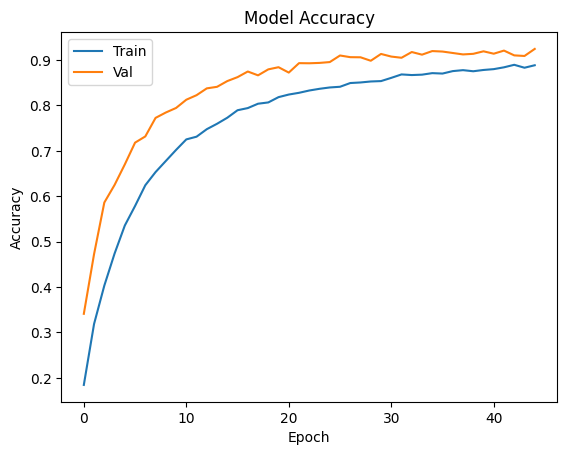

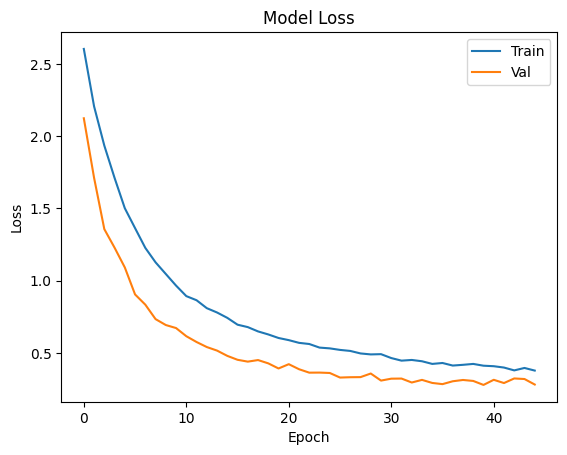

In [28]:
plot_acc(m2_hist)
plot_loss(m2_hist)

In [29]:
m2_score = m2.evaluate(X_test, y_test, verbose=True)

print("Evaluación del modelo (Datos de test) - Loss : " + str(m2_score[0]))
print("Evaluación del modelo (Datos de test) - Accuracy : " + str(m2_score[1]))
print("Accuracy (Datos de test) en % : " + str(m2_score[1]*100))

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9432 - loss: 0.1883
Evaluación del modelo (Datos de test) - Loss : 0.17937476933002472
Evaluación del modelo (Datos de test) - Accuracy : 0.9460673928260803
Accuracy (Datos de test) en % : 94.60673928260803


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


<Figure size 1000x800 with 0 Axes>

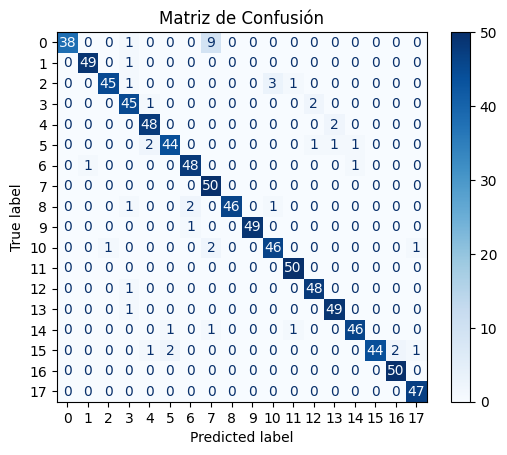

In [30]:
# Predecir las clases en los datos de prueba
y_pred = np.argmax(m2.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Generar la matriz de confusión
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(len(np.unique(y_true)))])

# Mostrar la matriz de confusión
plt.figure(figsize=(10, 8))
cm_display.plot(cmap=plt.cm.Blues, values_format='g')
plt.title('Matriz de Confusión')
plt.show()


In [31]:
y_pred = np.argmax(m2.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
report = classification_report(y_true, y_pred, target_names=[f'Clase {i} {MAP_CHARACTERS[i]}' for i in range(len(np.unique(y_true)))])
print("\nInforme de clasificación:\n", report)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Informe de clasificación:
                                   precision    recall  f1-score   support

  Clase 0 abraham_grampa_simpson       1.00      0.79      0.88        48
  Clase 1 apu_nahasapeemapetilon       0.98      0.98      0.98        50
            Clase 2 bart_simpson       0.98      0.90      0.94        50
Clase 3 charles_montgomery_burns       0.88      0.94      0.91        48
            Clase 4 chief_wiggum       0.92      0.96      0.94        50
          Clase 5 comic_book_guy       0.94      0.90      0.92        49
          Clase 6 edna_krabappel       0.94      0.96      0.95        50
           Clase 7 homer_simpson       0.81      1.00      0.89        50
           Clase 8 kent_brockman       1.00      0.92      0.96        50
        Clase 9 krusty_the_clown       1.00      0.98      0.99        50
           Clase 10 lisa_simpson       0.92      0.92      0.92        50
          Clase 11 marge_simpson       0.96 

In [32]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

def create_model(learning_rate=0.001, dropout_rate=0.5):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_categ, activation="softmax"))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=32, verbose=1,dropout_rate=0.3,learning_rate=0.01)

param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'dropout_rate': [0.3, 0.5, 0.7],
    'batch_size': [32, 64, 128],
    'epochs': [10, 20, 30]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

print("Mejores parámetros: %s usando %s" % (grid_result.best_score_, grid_result.best_params_))

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-26 20:14:07.210388: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-05-26 20:14:07.210444: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-05-26 20:14:07.210452: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-05-26 20:14:07.210490: I tenso

Epoch 1/10


/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-26 20:14:09.499066: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-05-26 20:14:09.499097: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-05-26 20:14:09.499107: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-05-26 20:14:09.499128: I tenso

Epoch 1/10
Epoch 1/10
Epoch 1/20
Epoch 1/10
Epoch 1/10
Epoch 1/20
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
 11/317 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.0376 - loss: 11660.1758

2024-05-26 20:14:14.954551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-05-26 20:14:14.958622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-05-26 20:14:14.959019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-05-26 20:14:14.978708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-05-26 20:14:15.016427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-05-26 20:14:15.047242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-05-26 20:14:15.049615: I tensorflow/core/grappler/optimizers/cust

103/317 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.0883 - loss: 2605.8413

KeyboardInterrupt: 

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(dropout_rate))
model.add(Dense(num_categ, activation="softmax"))

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

grid_result = grid.fit(X_train, y_train)